In [5]:
from produto import Produto
from caixa import Caixa
from estoque import Estoque
from onda import Onda

from pyspark.sql import SparkSession
from pyspark import SparkConf

# Configuração inicial do PySpark
conf = SparkConf()
conf.setAppName("MeuAplicativoPySpark")
conf.setMaster("local[*]")  # Usar todos os núcleos locais para execução

# Criação da SparkSession
spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()

In [6]:
# Verificar se a sessão Spark está funcionando
print("SparkSession Criada!")
spark.sparkContext.setLogLevel("WARN")  # Define o nível de log para evitar muitas mensagens de depuração

# Leitura de dois arquivos CSV e salvando em variáveis
caixas_df = spark.read.csv("../data/caixas.csv", header=True, inferSchema=True)
estoque_df = spark.read.csv("../data/estoque.csv", header=True, inferSchema=True)

# Mostrando o conteúdo dos DataFrames
caixas_df.show(1)
estoque_df.show(1)


SparkSession Criada!
+-------+--------+-----+-------------+-----+
|ONDA_ID|CAIXA_ID|PECAS|  CLASSE_ONDA|  SKU|
+-------+--------+-----+-------------+-----+
|      4|      12|    1|CLASSE_ONDA_1|SKU_1|
+-------+--------+-----+-------------+-----+
only showing top 1 row

+-----+--------+---------+-----+
|ANDAR|CORREDOR|      SKU|PECAS|
+-----+--------+---------+-----+
|    0|       2|SKU_17028|  193|
+-----+--------+---------+-----+
only showing top 1 row



In [7]:
# Criando uma visão temporária para utilizar SQL puro
caixas_df.createOrReplaceTempView("caixas")
estoque_df.createOrReplaceTempView("estoque")

In [8]:

# Agregando as quantidades de cada SKU por classe de onda e caixa
agregado_caixa = spark.sql("""
    SELECT
        CLASSE_ONDA,
        CAIXA_ID,
        SKU,
        PECAS
    FROM caixas

""")
agregado_caixa.createOrReplaceTempView("agregado_caixa")

# Agregando as quantidades de cada SKU por andar
agregado_estoque = spark.sql("""
    SELECT
        ANDAR,
        SKU,
        SUM(PECAS) AS TOTAL_PECAS_DISPONIVEIS
    FROM estoque
    GROUP BY
        ANDAR, SKU
""")
agregado_estoque.createOrReplaceTempView("agregado_estoque")

# Verificando quantas peças são necessárias em cada caixa e quantas temos no andar
dados_necessarios_disponiveis = spark.sql("""
    SELECT
        ac.CLASSE_ONDA,
        ac.CAIXA_ID,
        ae.ANDAR,
        ac.SKU,
        ac.PECAS AS TOTAL_PECAS_NECESSARIAS,
        ae.TOTAL_PECAS_DISPONIVEIS,
        (ae.TOTAL_PECAS_DISPONIVEIS - ac.PECAS) AS DIFF
        
    FROM agregado_caixa ac
    LEFT JOIN agregado_estoque ae
    ON ac.SKU = ae.SKU
    ORDER BY
        ac.CLASSE_ONDA, ac.CAIXA_ID, ae.ANDAR
""")
dados_necessarios_disponiveis.show()

+-------------+--------+-----+------+-----------------------+-----------------------+----+
|  CLASSE_ONDA|CAIXA_ID|ANDAR|   SKU|TOTAL_PECAS_NECESSARIAS|TOTAL_PECAS_DISPONIVEIS|DIFF|
+-------------+--------+-----+------+-----------------------+-----------------------+----+
|CLASSE_ONDA_1|      12|    0| SKU_2|                      1|                     84|  83|
|CLASSE_ONDA_1|      12|    0| SKU_3|                      1|                    852| 851|
|CLASSE_ONDA_1|      12|    0| SKU_4|                      1|                    670| 669|
|CLASSE_ONDA_1|      12|    0| SKU_6|                      4|                    233| 229|
|CLASSE_ONDA_1|      12|    0| SKU_9|                      4|                    152| 148|
|CLASSE_ONDA_1|      12|    0|SKU_11|                      1|                      1|   0|
|CLASSE_ONDA_1|      12|    0|SKU_12|                      2|                    132| 130|
|CLASSE_ONDA_1|      12|    0|SKU_14|                      8|                    271| 263|

In [9]:
# Filtrando os casos onde o DIFF > 0
caixas_easy = dados_necessarios_disponiveis.filter("DIFF >= 0")
caixas_easy.count()

23299

In [10]:
caixas_hard = dados_necessarios_disponiveis.filter("DIFF < 0")
caixas_hard.count()

218

In [11]:
caixas = {}

for row in caixas_df.collect():
    onda_id = row['ONDA_ID']
    caixa_id = row['CAIXA_ID']
    classe_onda = row['CLASSE_ONDA']
    classe_onda = int(classe_onda.split('_')[-1])
    sku = row['SKU']
    sku = int(sku.split('_')[1])
    qtd = row['PECAS']
    
    # Criar ou buscar a caixa existente
    if caixa_id not in caixas:
        caixa = Caixa(caixa_id, classe_onda, onda_id)
        caixas[caixa_id] = caixa
    else:
        caixa = caixas[caixa_id]
    
    # Adicionar o produto à caixa
    produto = Produto(sku, qtd)
    caixa.add_produto(produto)

print(len(caixas))
print(caixas[12].get_total_itens())

2072
68


In [12]:
estoques = {}
for row in estoque_df.collect():

    andar = row['ANDAR']
    corredor = row['CORREDOR']
    sku = row['SKU']
    sku = int(sku.split('_')[1])
    qtd = row['PECAS']
    
    # Criar ou buscar o estoque existente
    if (andar, corredor) not in estoques:
        estoque = Estoque(andar, corredor)
        estoques[(andar, corredor)] = estoque
    
    else:
        estoque = estoques[(andar, corredor)]

    # Adicionar o produto ao estoque
    produto = Produto(sku, qtd)
    estoque.add_produto(produto)

print(len(estoques))
print(estoques[(0, 2)].get_total_itens())

502
1615


In [13]:
caixas_classe1 = {}
caixas_classe2 = {}
caixas_classe3 = {}
caixas_classe4 = {}
caixas_classe5 = {}
caixas_classe6 = {}

for caixa in caixas.values():
    if caixa.classe_onda == 1:
        caixas_classe1[caixa.id_caixa] = caixa
    elif caixa.classe_onda == 2:
        caixas_classe2[caixa.id_caixa] = caixa
    elif caixa.classe_onda == 3:
        caixas_classe3[caixa.id_caixa] = caixa
    elif caixa.classe_onda == 4:
        caixas_classe4[caixa.id_caixa] = caixa
    elif caixa.classe_onda == 5:
        caixas_classe5[caixa.id_caixa] = caixa
    else:
        caixas_classe6[caixa.id_caixa] = caixa

print(f"Caixas classe 1: {len(caixas_classe1)}")
print(f"Caixas classe 2: {len(caixas_classe2)}")
print(f"Caixas classe 3: {len(caixas_classe3)}")
print(f"Caixas classe 4: {len(caixas_classe4)}")
print(f"Caixas classe 5: {len(caixas_classe5)}")
print(f"Caixas classe 6: {len(caixas_classe6)}")

Caixas classe 1: 1133
Caixas classe 2: 416
Caixas classe 3: 321
Caixas classe 4: 153
Caixas classe 5: 47
Caixas classe 6: 2


In [41]:
caixas_andar_0 = {}
caixas_andar_1 = {}
caixas_andar_2 = {}
caixas_varios = {}

for caixa in caixas_classe1.values():

    total_prod = 0

    andares_possiveis = []
    corredores_possiveis = []

    opcoes = {
        "0": 0,
        "1": 0,
        "2": 0,
        "10": 0,
        "20": 0,
        "21": 0,
        "210": 0
    }

    for produto in caixa.produtos:

        andares_achados = set()
        corredores_achados = []
        achou = False

        total_prod += 1
        sku = produto.sku
        qtd = produto.qtd

        for estoque in estoques.values():
            produto_estoque = estoque.get_produto(sku)

            if produto_estoque is not None and produto_estoque.qtd >= qtd:
                andares_achados.add(estoque.andar)
                corredores_achados.append((estoque.andar, estoque.corredor))
                achou = True

        if achou:
            for andar in andares_achados:
                if andar == 0:
                    opcoes["0"] += 1
                    opcoes["10"] += 1
                    opcoes["20"] += 1
                    opcoes["210"] += 1
                
                elif andar == 1:
                    opcoes["1"] += 1
                    opcoes["21"] += 1
                    opcoes["10"] += 1
                    opcoes["210"] += 1

                elif andar == 2:
                    opcoes["2"] += 1
                    opcoes["20"] += 1
                    opcoes["21"] += 1
                    opcoes["210"] += 1

        corredores_possiveis.append(corredores_achados)

    for opcao, qtd in opcoes.items():
        
        if qtd >= total_prod and total_prod > 0:  
            andares_possiveis.append(opcao)

    for a in andares_possiveis:
        caixa.andar.append(a)

    #print(f"Caixa (andar) {caixa.id_caixa} - Andares possíveis: {caixa.andar}")

for caixa in caixas.values():
    if (caixa.andar == []):
        print(caixa.id_caixa)




249
6071
6112
6128
6406
3514


Classe 1 - A: 824, B: 0, C: 5, AB: 0, AC: 0, BC: 0, ABC: 0


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


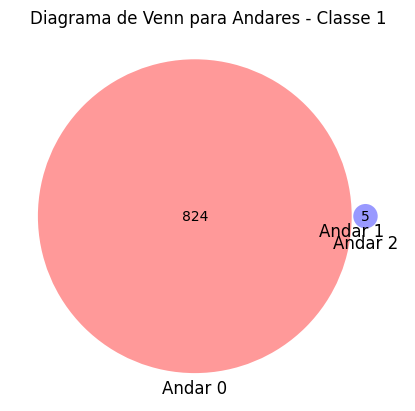

Classe 2 - A: 18, B: 35, C: 0, AB: 9, AC: 0, BC: 0, ABC: 0


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:111: UserWarning: Circle C has zero area.
  warnings.warn("Circle C has zero area.")


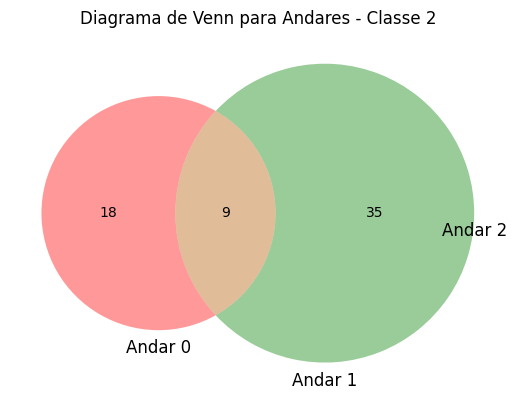

Classe 3 - A: 307, B: 0, C: 0, AB: 0, AC: 0, BC: 0, ABC: 0


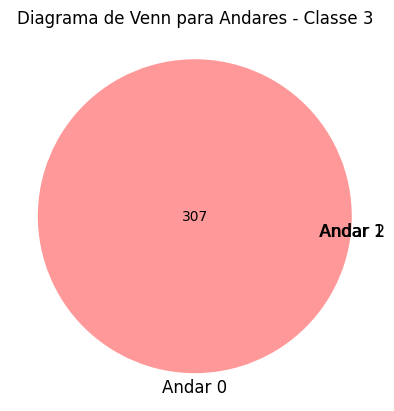

Classe 4 - A: 74, B: 0, C: 0, AB: 0, AC: 0, BC: 0, ABC: 0


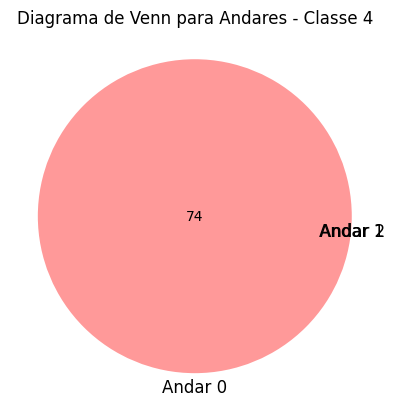

Classe 5 - A: 35, B: 0, C: 0, AB: 0, AC: 0, BC: 0, ABC: 0


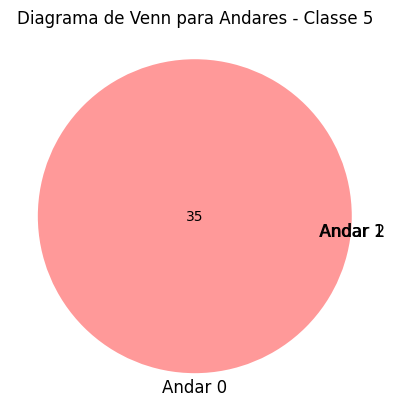

Classe 6 - A: 2, B: 0, C: 0, AB: 0, AC: 0, BC: 0, ABC: 0


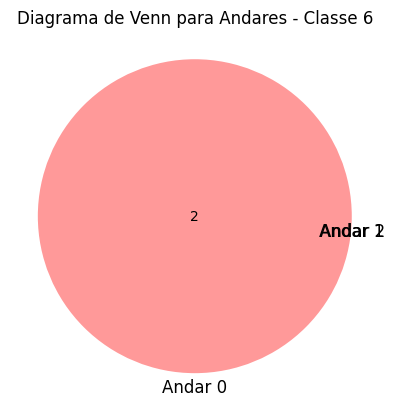

In [48]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Criar um dicionário que mapeia cada classe de onda
caixas_classe_dict = {
    1: caixas_classe1,
    2: caixas_classe2,
    3: caixas_classe3,
    4: caixas_classe4,
    5: caixas_classe5,
    6: caixas_classe6
}

# Loop para cada classe de onda (1 a 6)
for i in range(1, 7):

    # Inicializando contadores
    A = 0  # Apenas andar 0
    B = 0  # Apenas andar 1
    C = 0  # Apenas andar 2
    AB = 0  # Andares 0 e 1
    AC = 0  # Andares 0 e 2
    BC = 0  # Andares 1 e 2
    ABC = 0  # Andares 0, 1 e 2

    # Acessar a classe de onda correta a partir do dicionário
    caixas_classe = caixas_classe_dict[i]

    # Verificando cada caixa em caixas_classe.values()
    for caixa in caixas_classe.values():
        # Remover duplicatas da lista 'andar'
        andares_unicos = list(set(caixa.andar))
        
        # Filtrando apenas andares "0", "1" e "2"
        andares_filtrados = [andar for andar in andares_unicos if andar in {"0", "1", "2"}]

        
        # Convertendo a lista filtrada de andares em um set para facilitar a comparação
        andares = set(andares_filtrados)
        
        # Verificar as combinações de andares
        if andares == {"0", "1", "2"}:
            ABC += 1
        elif andares == {"0", "1"}:
            AB += 1
        elif andares == {"0", "2"}:
            AC += 1
        elif andares == {"1", "2"}:
            BC += 1
        elif andares == {"0"}:
            A += 1
        elif andares == {"1"}:
            B += 1
        elif andares == {"2"}:
            C += 1

    # Imprimindo os valores para depuração
    print(f"Classe {i} - A: {A}, B: {B}, C: {C}, AB: {AB}, AC: {AC}, BC: {BC}, ABC: {ABC}")

    # Criando o diagrama de Venn com os valores calculados
    venn = venn3(subsets=(A, B, AB, C, AC, BC, ABC), set_labels=('Andar 0', 'Andar 1', 'Andar 2'))

    # Mostrando o gráfico
    plt.title(f"Diagrama de Venn para Andares - Classe {i}")
    plt.show()

Classe 1 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 104


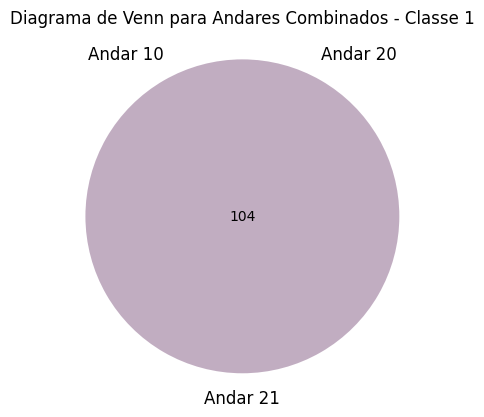

Classe 2 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 134


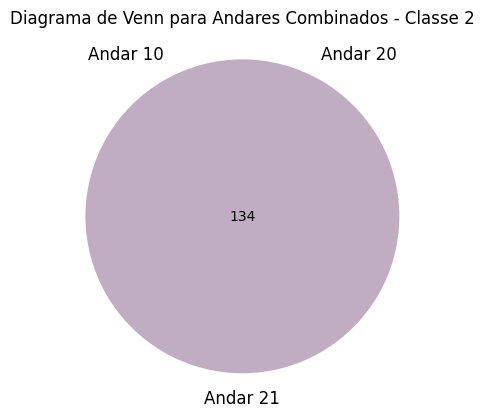

Classe 3 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 0


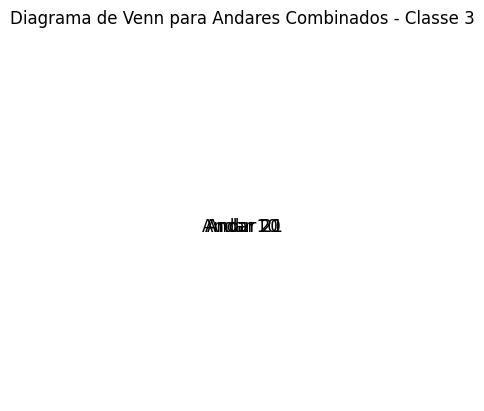

Classe 4 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 38


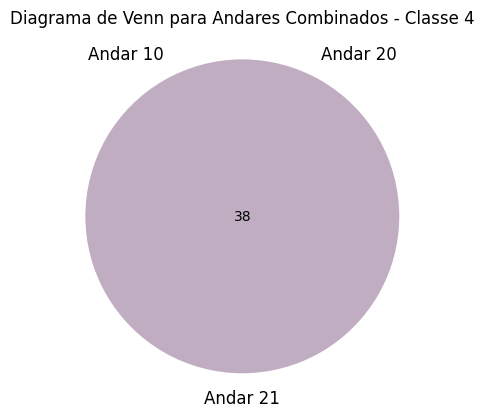

Classe 5 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 0


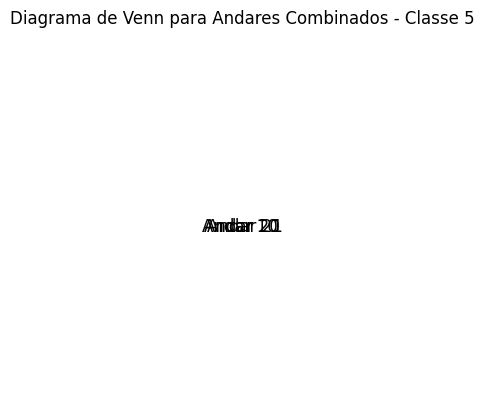

Classe 6 - AB (10): 0, AC (20): 0, BC (21): 0, ABC (210): 0


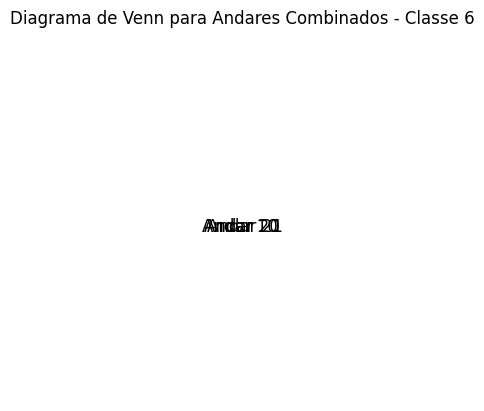

In [50]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Criar um dicionário que mapeia cada classe de onda
caixas_classe_dict = {
    1: caixas_classe1,
    2: caixas_classe2,
    3: caixas_classe3,
    4: caixas_classe4,
    5: caixas_classe5,
    6: caixas_classe6
}

# Loop para cada classe de onda (1 a 6)
for i in range(1, 7):

    # Inicializando contadores
    A = 0  # Será sempre 0
    B = 0  # Será sempre 0
    C = 0  # Será sempre 0
    AB = 0  # Combinacao 10
    AC = 0  # Combinacao 20
    BC = 0  # Combinacao 21
    ABC = 0  # Combinacao 210

    # Acessar a classe de onda correta a partir do dicionário
    caixas_classe = caixas_classe_dict[i]

    # Verificando cada caixa em caixas_classe.values()
    for caixa in caixas_classe.values():
        # Remover duplicatas da lista 'andar'
        andares_unicos = list(set(caixa.andar))

        # Ignorar se a caixa contém EXATAMENTE os andares "0", "1" e "2"
        if set(andares_unicos) == {"0", "1", "2"}:
            continue  # Ignora essa caixa pois pertence ao primeiro diagrama

        # Convertendo a lista de andares únicos em um set para facilitar a comparação
        andares = set(andares_unicos)
        
        # Verificar as combinações de "10", "20", "21", "210"
        if andares == {"210"}:
            ABC += 1
        elif andares == {"10"}:
            AB += 1
        elif andares == {"20"}:
            AC += 1
        elif andares == {"21"}:
            BC += 1

    # Imprimindo os valores para depuração
    print(f"Classe {i} - AB (10): {AB}, AC (20): {AC}, BC (21): {BC}, ABC (210): {ABC}")

    # Criando o diagrama de Venn com os valores calculados
    venn = venn3(subsets=(A, B, AB, C, AC, BC, ABC), set_labels=('Andar 10', 'Andar 20', 'Andar 21'))

    # Mostrando o gráfico
    plt.title(f"Diagrama de Venn para Andares Combinados - Classe {i}")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Criar um dicionário que mapeia cada classe de onda
caixas_classe_dict = {
    1: caixas_classe1,
    2: caixas_classe2,
    3: caixas_classe3,
    4: caixas_classe4,
    5: caixas_classe5,
    6: caixas_classe6
}

# Loop para cada classe de onda (1 a 6)
for i in range(1, 7):
    # Acessar a classe de onda correta a partir do dicionário
    caixas_classe = caixas_classe_dict[i]

    # Verificando cada caixa em caixas_classe.values()
    for caixa in caixas_classe.values():
        # Remover duplicatas da lista 'andar'
        andares_unicos = list(set(caixa.andar))

        # Ignorar se a caixa contém EXATAMENTE os andares "0", "1" e "2"
        if set(andares_unicos) == {"0", "1", "2"}:
            continue  # Ignora essa caixa pois pertence ao primeiro diagrama

        # Convertendo a lista de andares únicos em um set para facilitar a comparação
        andares = set(andares_unicos)
        
        # Verificar as combinações de "10", "20", "21", "210"
        if andares == {"210"}:
            ABC += 1
        elif andares == {"10"}:
            AB += 1
        elif andares == {"20"}:
            AC += 1
        elif andares == {"21"}:
            BC += 1

   